In [1]:
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import ImageFilter

height, width = 224, 224
batch_size=64


def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'damaged': 0, 'undamaged': 1}
    )
    return generator

TRAINING_DIR = '/kaggle/input/damageclassification/train'
TESTING_DIR = '/kaggle/input/damageclassification/test'

train_generator = generate_data(TRAINING_DIR)
test_generator = generate_data(TESTING_DIR)

total_image = np.concatenate([train_generator.labels,test_generator.labels])

print('\n\n',{'damaged':len(np.where(total_image==0)[0]),
      'undamaged':len(np.where(total_image==1)[0])})

Found 3880 images belonging to 2 classes.
Found 546 images belonging to 2 classes.


 {'damaged': 1786, 'undamaged': 2640}


<h3>Images demonstration<h3>

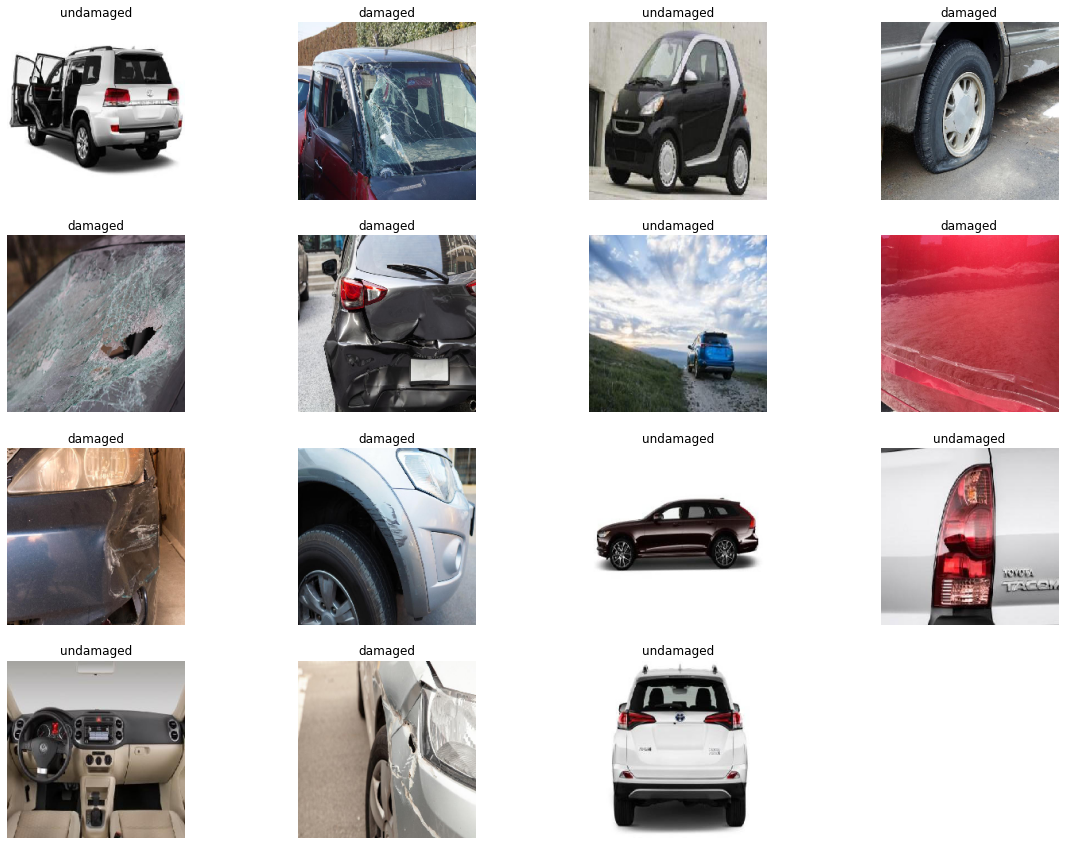

In [3]:
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        plt.title("damaged" if img_label[i] == 0 else "undamaged")
        plt.axis("off")

image_plot(train_generator,15)

<h3>VGG16 implementation</h3>

The reason that I added 2 more dense layers is to identify more clearly from the grayscale image.

The dropout layers are regularization for preventing overfitting.

In [4]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg16 = tf.keras.Sequential()
model_vgg16.add(base_model)
model_vgg16.add(tf.keras.layers.GlobalAveragePooling2D())

model_vgg16.add(tf.keras.layers.Flatten())
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))

model_vgg16.add(tf.keras.layers.Dense(3, activation='softmax'))

model_vgg16.compile(loss='SparseCategoricalCrossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
model_vgg16.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________

In [5]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

callbacks_list = [checkpoint,early]

history = model_vgg16.fit(
        train_generator,
        validation_data = test_generator,
        #steps_per_epoch=10,
        epochs=50, 
        shuffle=False, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/50
61/61 [==============================] - 74s 1s/step - loss: 0.4703 - acc: 0.7693 - val_loss: 0.2361 - val_acc: 0.9103

Epoch 00001: acc improved from -inf to 0.76933, saving model to model/vgg16_best.h5
Epoch 2/50
61/61 [==============================] - 31s 510ms/step - loss: 0.2412 - acc: 0.9028 - val_loss: 0.1389 - val_acc: 0.9432

Epoch 00002: acc improved from 0.76933 to 0.90284, saving model to model/vgg16_best.h5
Epoch 3/50
61/61 [==============================] - 31s 510ms/step - loss: 0.1875 - acc: 0.9255 - val_loss: 0.1175 - val_acc: 0.9560

Epoch 00003: acc improved from 0.90284 to 0.92552, saving model to model/vgg16_best.h5
Epoch 4/50
61/61 [==============================] - 31s 508ms/step - loss: 0.1556 - acc: 0.9405 - val_loss: 0.0872 - val_acc: 0.9670

Epoch 00004: acc improved from 0.92552 to 0.94046, saving model to model/vgg16_best.h5
Epoch 5/50
61/61 [==============================] - 31s 500ms/step - loss: 0.1426 - acc: 0.9466 - val_loss: 0.1217 - val_a

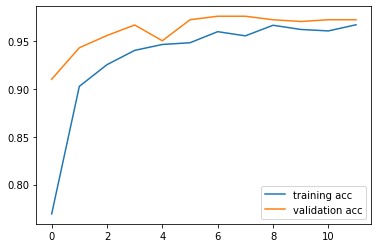

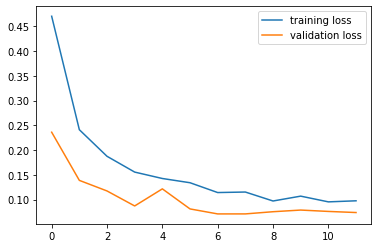

In [6]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend();

plot_learning_curve(history)

In [7]:
train_result = model_vgg16.evaluate(train_generator)
test_result = model_vgg16.evaluate(test_generator)

no_augmented_df = pd.DataFrame(zip(train_result,test_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

9/9 [==============================] - 4s 412ms/step - loss: 0.0711 - acc: 0.9762


,Train,Val
Loss,0.082345,0.071116
Acc,0.968299,0.976190


              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       218
         1.0       0.98      0.98      0.98       328

    accuracy                           0.98       546
   macro avg       0.98      0.97      0.98       546
weighted avg       0.98      0.98      0.98       546



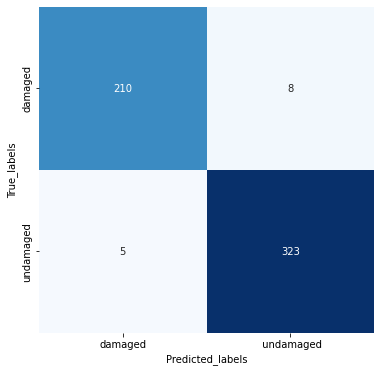

In [8]:
ytest = np.array([])
xtest = []

for i in range(math.ceil(len(test_generator.classes)/batch_size)):
    xtest.append(test_generator[i][0]) 
    ytest= np.concatenate((ytest,test_generator[i][-1])) 
    
xtest = np.concatenate((xtest),axis=0)

ypred_prob =model_vgg16.predict(xtest)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['damaged',' undamaged'],yticklabels=['damaged','undamaged'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytest,ypred))

<h3>Show the wrong classified image</h3>

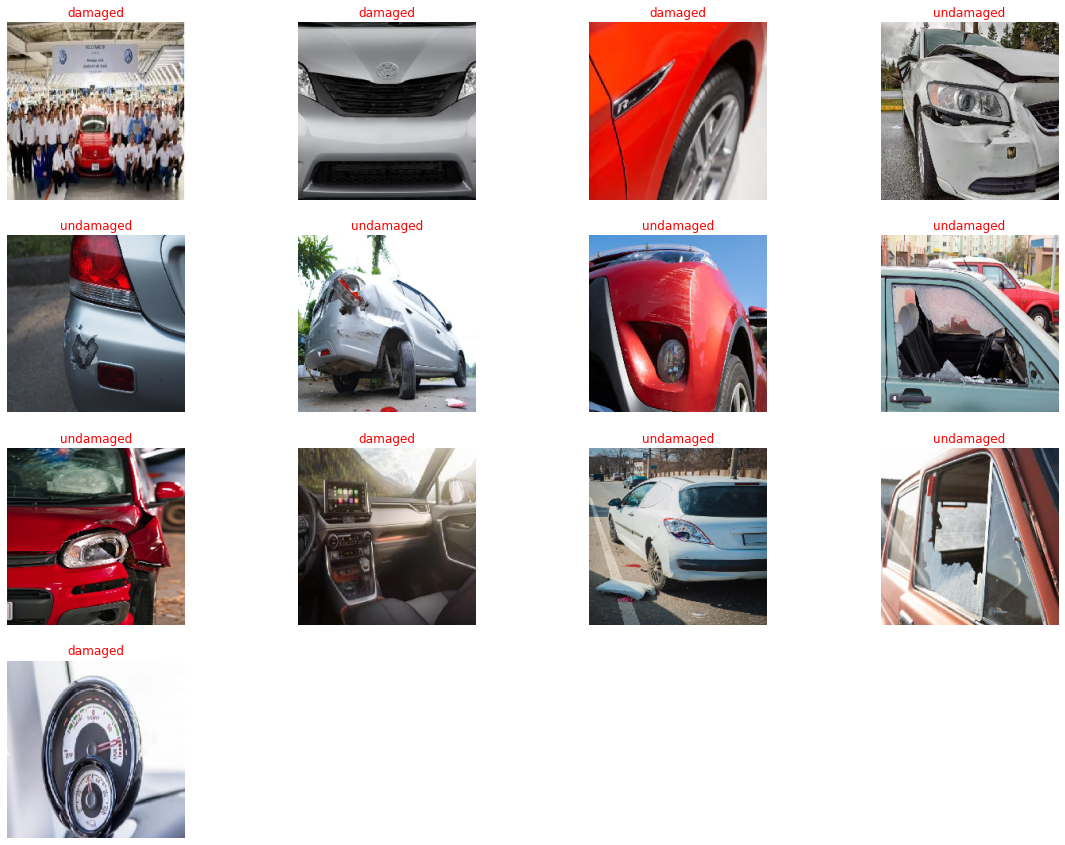

In [9]:
#Extract wrong classification index
wrong_pred = np.where(ypred!=ytest)[0]

plt.figure(figsize=(20, 15))
for i,n in enumerate(wrong_pred):
    ax = plt.subplot(math.ceil(len(wrong_pred)/4),4, i + 1)
    plt.imshow(xtest[n])
    plt.title("damaged" if ypred[n] == 0 else "undamaged",color='r')
    plt.axis("off")

Well, actually they looks similar 🙃

<h3>Adding image augmentation</h3>

<h3>Final model evaluation</h3>

For training dataset

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      1568
         1.0       0.97      0.98      0.97      2312

    accuracy                           0.97      3880
   macro avg       0.97      0.97      0.97      3880
weighted avg       0.97      0.97      0.97      3880



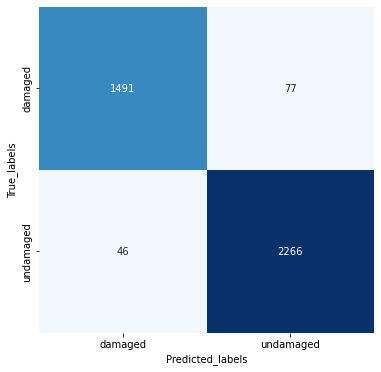

In [10]:
ytrain = np.array([])
xtrain = []

for i in range(math.ceil(len(train_generator.classes)/batch_size)):
    xtrain.append(train_generator[i][0]) 
    ytrain= np.concatenate((ytrain,train_generator[i][-1])) 
    
xtrain = np.concatenate((xtrain),axis=0)

ypred_prob =model_vgg16.predict(xtrain)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytrain,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['damaged','undamaged'],yticklabels=['damaged','undamaged'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytrain,ypred))

For testing dataset

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       218
         1.0       0.98      0.98      0.98       328

    accuracy                           0.98       546
   macro avg       0.98      0.97      0.98       546
weighted avg       0.98      0.98      0.98       546



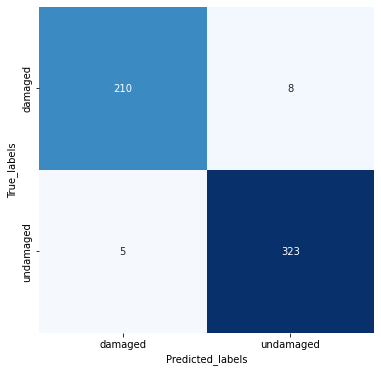

In [11]:
ytest = np.array([])
xtest = []

for i in range(math.ceil(len(test_generator.classes)/batch_size)):
    xtest.append(test_generator[i][0]) 
    ytest= np.concatenate((ytest,test_generator[i][-1])) 
    
xtest = np.concatenate((xtest),axis=0)

ypred_prob =model_vgg16.predict(xtest)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['damaged','undamaged'],yticklabels=['damaged','undamaged'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytest,ypred))

In [12]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import tensorflow as tf

# Specify the path to your input image
image_path = '/kaggle/input/damageclassification/train/damaged/000007_jpg.rf.53b27a16c0a125c5f8616cf70b104867.jpg'

# Load the image and preprocess it
image = load_img(image_path, target_size=(height, width))
image = img_to_array(image)
image = image / 255.0  # Normalize the image
image = image[tf.newaxis, ...]  # Expand dimensions to match the model's input shape

# Perform prediction
predictions = model_vgg16.predict(image)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Map the class index to the class label
class_labels = {0: 'damaged', 1: 'undamaged'}
predicted_label = class_labels[predicted_class]

print(f"The predicted class is: {predicted_label}")


The predicted class is: damaged


<h2>

Great!!

The model can classify all the covid image correctly and overall the accuracy can achieve 98%.

Thanks for viewing my works
    
Your comment matters to me and please feel free to leave it
    
Please upvote if you love it 😀</h2>